<a href="https://colab.research.google.com/github/morris1961/Data-Structures-and-Advanced-Program-Design/blob/master/ethnicity_classification_olympic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [1]:
%cd /content/drive/Shareddrives/weilao_research/olympic

/content/drive/Shareddrives/weilao_research/olympic


In [25]:
import io
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import unicodedata as ud
import copy
import random
import matplotlib.pyplot as plt
import tqdm
import torch

import sys
sys.path.append('./')
from Preprocess import *
from Skipgram import *

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Dot, Embedding, Flatten, GlobalAveragePooling1D, Reshape, Input, Conv1D, MaxPooling1D, concatenate, Dropout
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN

# **Read Data**

In [3]:
athlete = pd.read_csv('./data/athlete_events.csv')
athlete = athlete[["Name", "NOC"]]
# display(athlete)

# **Preprocessing**

## **Getting Unique Values**

In [4]:
athlete_unique = uniqueIndices(athlete)
display(athlete_unique.head())

,Name,NOC
0,A Dijiang,CHN
1,A Lamusi,CHN
2,Gunnar Nielsen Aaby,DEN
3,Edgar Lindenau Aabye,DEN
4,Christine Jacoba Aaftink,NED


## **Map Ethnicity**

In [5]:
athlete_ethnicty = copy.deepcopy(athlete_unique)
athlete_ethnicty['ethnicity'] = athlete_ethnicty['NOC'].apply(lambda m: NOC_to_ethnicity(m))
display(athlete_ethnicty.head())

,Name,NOC,ethnicity
0,A Dijiang,CHN,eastasian
1,A Lamusi,CHN,eastasian
2,Gunnar Nielsen Aaby,DEN,nordic
3,Edgar Lindenau Aabye,DEN,nordic
4,Christine Jacoba Aaftink,NED,european


### **Distribution Bar Chart**

[]

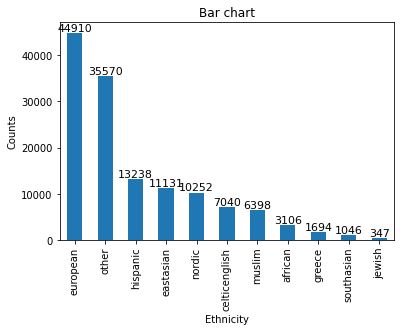

In [6]:
X = [0,1,2,3,4,5,6,7,8,9,10]
ethnicity_counts = athlete_ethnicty['ethnicity'].value_counts()
mapping_bar_chart = ethnicity_counts.plot.bar()

#使用text顯示數值  
for a,b in zip(X,ethnicity_counts):  
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=11) 

plt.xlabel('Ethnicity')
plt.ylabel('Counts')
plt.title('Bar chart')
plt.plot()

## **Drop Low Frequency Ethnicities**

Here we will temporarily drop 
* `other` (unable to predict)
* (sample size too small)

### **Distribution Bar Chart**

In [7]:
athlete_ethnicty = DropLowFre(athlete_ethnicty, 4000)

[]

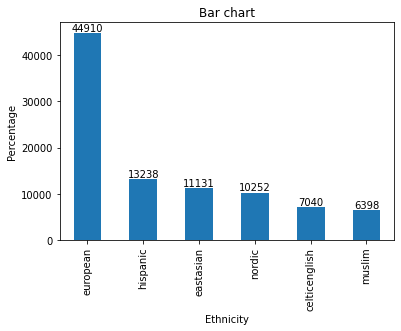

In [8]:
ethnicity_percent = athlete_ethnicty['ethnicity'].value_counts()
X = [0,1,2,3,4,5,6,7,8,9]
mapping_bar_chart = ethnicity_percent.plot.bar()

#使用text顯示數值  
for a,b in zip(X,ethnicity_percent):  
  plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10) 

plt.xlabel('Ethnicity')
plt.ylabel('Percentage')
plt.title('Bar chart')
plt.plot()

## **Map EASCII to ASCII**

In [9]:
athlete_name = copy.deepcopy(athlete_ethnicty['Name'])
english_name = ["" for i in range(len(athlete_name))]
for i in range(len(athlete_name)): # len(athlete_name)
    english_name[i] = translater(athlete_name[i])
print(len(english_name))
print(english_name[0:5])

92969
['$a$$dijiang$', '$a$$lamusi$', '$gunnar$$nielsen$$aaby$', '$edgar$$lindenau$$aabye$', '$christine$$jacoba$$aaftink$']


In [10]:
# # 用來檢查是否還有符號存在(漏刪除) 但應該沒有啦：)
# # 白名單 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '+', '$', '.', '\'']
# # 如果要用的話
# test = list(copy.deepcopy(english_name))
# for name in test:
#   for cha in name:
#     if cha not in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '+', '$', '.', "'"]:
#       print(name)

## **Bi-gram preprocessing**

In [11]:
bi_name = bigramProcessor(english_name)
print(bi_name[0])

['$a', 'a$', '$$', '$d', 'di', 'ij', 'ji', 'ia', 'an', 'ng', 'g$']


### **Bi-gram Length Histogram**

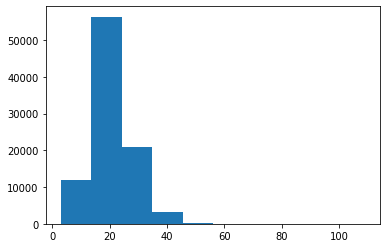

In [12]:
total = len(bi_name)
l = [len(bi_name[i]) for i in range(len(bi_name))]
l.sort()
plt.hist(l)
plt.show()

# **Character Representation (Skip Gram)**

In [17]:
isSave = True
MYSEED = 1126
embedding_dim = 256
BATCH_SIZE = 64
MAX_SEQUENCE_LENGTH = 30

In [15]:
vocab, vocabulary, inverse_vocab, sequence = Biname2sequence(bi_name, MAX_SEQUENCE_LENGTH)
if not isSave:
  tf.random.set_seed(MYSEED)
  window_size = 5
  num_ns = 5
  targets, contexts, labels = generate_training_data(
                        sequences=sequence,
                        window_size=window_size,
                        num_ns=num_ns,
                        vocab_size=len(vocab),
                        seed=MYSEED)
  
  weights = SkipGram(targets, contexts, labels, vocab, num_ns, embedding_dim, MYSEED, 10000, BATCH_SIZE)
  # out_v = io.open("vectors.tsv", "w", encoding="utf-8")
  # for index, word in enumerate(vocabulary):
  #     vec = weights[index]
  #     out_v.write("\t".join([str(x) for x in vec]) + "\n")
  # out_v.close()
else:
  weights = []
  file = open('vectors.tsv', 'r', encoding='utf-8')
  for line in file:
    temp_values = line.split()
    values = [float(temp_values[i]) for i in range(len(temp_values))]
    coefs = np.asarray(values, dtype='float32')
    weights.append(coefs)
  file.close()
  

vocabulary size = 767
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] len = 30



Epoch 1/10
19521/19521 [==============================] - 129s 7ms/step - loss: 1.0851 - accuracy: 0.5870
Epoch 2/10
19521/19521 [==============================] - 134s 7ms/step - loss: 0.9625 - accuracy: 0.6351
Epoch 3/10
19521/19521 [==============================] - 135s 7ms/step - loss: 0.9501 - accuracy: 0.6390
Epoch 4/10
19521/19521 [==============================] - 139s 7ms/step - loss: 0.9434 - accuracy: 0.6409
Epoch 5/10
19521/19521 [==============================] - 138s 7ms/step - loss: 0.9391 - accuracy: 0.6420
Epoch 6/10
19521/19521 [==============================] - 140s 7ms/step - loss: 0.9361 - accuracy: 0.6425
Epoch 7/10
19521/19521 [==============================] - 135s 7ms/step - loss: 0.9342 - accuracy: 0.6428
Epoch 8/10
19521/19521 [==============================] - 124s 6ms/step - loss: 0.9332 - accuracy: 0.6429
Epoch 9/10
19521/19521 [==============================] - 130s 7ms/step - loss: 0.9326 - accuracy: 0.6430
Epoch 10/10
19521/19521 [====================

In [18]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

distance_matrix = euclidean_distances(weights)
similar_words = {search_term: [inverse_vocab[idx] for idx in distance_matrix[vocab[search_term]].argsort()[1:6]] 
                   for search_term in vocabulary[0:5]}
similar_words

{'$$': ["'z", 'wv', 'qs', "h'", 'cf'],
 '$a': ['xc', 'vj', "q'", "'p", 'yx'],
 '$d': ['.f', 'vv', 'x.', 'xk', "'l"],
 '<pad>': ['yj', "h'", 'jp', 'vv', 'fw'],
 'a$': ['vv', "'z", '.f', 'wv', 'xm']}

## **Plot Embedded Bi-grams**

Total words: 30 	Word Embedding shapes: (30, 256)
['<pad>', 'yj', "h'", 'jp', 'vv', 'fw', '$a', 'xc', 'vj', "q'", "'p", 'yx', 'a$', 'vv', "'z", '.f', 'wv', 'xm', '$$', "'z", 'wv', 'qs', "h'", 'cf', '$d', '.f', 'vv', 'x.', 'xk', "'l"]


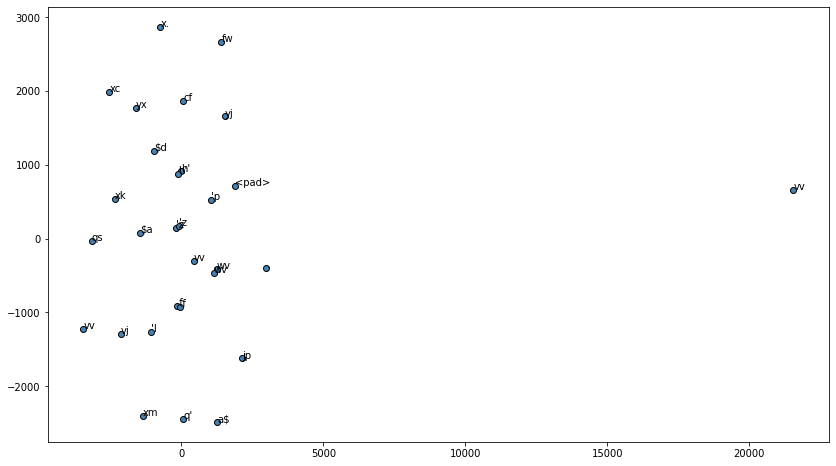

In [19]:
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [vocab[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=0)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
print(words)
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(words, T[:, 0], T[:, 1]):
    if label == "$$":
        label = "$.$"
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

"weights" is the embedding vectors of vocabular, and the length of weights is 128

In [20]:
for i in range(5):
  print(inverse_vocab[i], ":", weights[i][0:5], "...len =", len(weights[i]))

<pad> : [ 0.02777114 -0.00449574 -0.00299283  0.03505361  0.04536534] ...len = 256
$a : [-0.10540069 -0.52596956 -0.20181979  1.0633808   0.0380748 ] ...len = 256
a$ : [ 0.1619413   0.01532525  0.01756983 -0.53152573 -0.4017242 ] ...len = 256
$$ : [-0.05850507 -0.08836088 -0.12491047 -0.18418656 -0.0527864 ] ...len = 256
$d : [ 0.04981504  0.64851135  0.03737702 -0.09430211  0.39533377] ...len = 256


# **Construct Training Dataset**

In [35]:
random.seed(MYSEED)
tf.random.set_seed(MYSEED)
tf.compat.v1.set_random_seed(MYSEED)
np.random.seed(MYSEED)
AUTOTUNE=tf.data.AUTOTUNE

bi_name_train, bi_name_test, ethnicity_train, ethnicity_test = train_test_split(bi_name, athlete_ethnicty["ethnicity"].tolist(), test_size=0.2, random_state=MYSEED)
print(len(bi_name_train))
print(len(ethnicity_train))
# train_num = int(len(bi_name)*0.8)
# index_train = []
# while len(index_train) != train_num:
#   id = random.randint(1, len(bi_name))
#   if id not in index_train:
#     index_train.append(id)

# bi_name_train = []
# bi_name_test = []
# ethnicity_train = []
# ethnicity_test = []
# ethnicity = athlete['ethnicity'].tolist()

# for i in range(len(ethnicity)):
#   if i in index_train:
#     bi_name_train.append(bi_name[i])
#     ethnicity_train.append(ethnicity[i])
#   else:
#     bi_name_test.append(bi_name[i])
#     ethnicity_test.append(ethnicity[i])

74375
74375


In [ ]:
ETH_DIM = 6
def constructDataset(raw_biGrams, raw_ethnicity): # input: 2 lists
  # X
  print("bigram num: ", len(raw_biGrams))
  print("max sequence length: ", MAX_SEQUENCE_LENGTH)
  X = np.zeros((len(raw_biGrams), MAX_SEQUENCE_LENGTH))
  for i in range(len(raw_biGrams)):
    pad = False
    for j in range(MAX_SEQUENCE_LENGTH):
      X[i][j] = vocab[raw_biGrams[i][j]]
      if j == len(raw_biGrams[i]) - 1 and j < MAX_SEQUENCE_LENGTH:
        pad = True
        break
    if pad == True:
      j = len(raw_biGrams[i])
      while j < MAX_SEQUENCE_LENGTH:
          X[i][j] = vocab['<pad>']
          j += 1
    
  # y
  y = np.zeros((len(raw_biGrams), ETH_DIM))
  for i in range(len(raw_ethnicity)):
    if raw_ethnicity[i] == 'european':
      y[i][0] = 1
    elif raw_ethnicity[i] == 'hispanic':
      y[i][1] = 1
    elif raw_ethnicity[i] == 'eastasian':
      y[i][2] = 1
    elif raw_ethnicity[i] == 'nordic':
      y[i][3] = 1
    elif raw_ethnicity[i] == 'celticenglish':
      y[i][4] = 1
    elif raw_ethnicity[i] == 'muslim':
      y[i][5] = 1
  
  # convert to tensor
  X_tensor = tf.convert_to_tensor(X, dtype=tf.int64)
  y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
  return X_tensor, y_tensor

In [ ]:
X_train, y_train = constructDataset(bi_name_train, ethnicity_train)
X_test, y_test = constructDataset(bi_name_test, ethnicity_test)

bigram num:  74375
max sequence length:  30
bigram num:  18594
max sequence length:  30


# **Building Model**

## **Embedding Layer**

In [ ]:
def embedding_layer(weights, embedding_dim):
  embedding_index = weights
  embedding_matrix = np.zeros((len(embedding_index)+1, embedding_dim))
  for i in range(len(embedding_index)):
      embedding_matrix[i] = embedding_index[i]
  embeddingLayer = Embedding(len(embedding_index)+1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
  return embeddingLayer

## **LSTM Model**

In [ ]:
def LSTM_model(weights, embedding_dim, activate_lstm, activate_out, dropout, ETH_DIM, learning_rate):
  model = tf.keras.Sequential()
  model.add(embedding_layer(weights, embedding_dim))
  model.add(tf.keras.layers.LSTM(activation=activate_lstm, units=embedding_dim, dropout=dropout))
  model.add(Dense(units=ETH_DIM, activation=activate_out))
  model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=["categorical_accuracy"])
  return(model)
  

# **Training** 

## **Parameter Notes**
- `MAX_SEQUENCE_LENGTH = 30, BATCH_SIZE = 1024, EMBEDDING_DIM = 128` <br>
loss: 0.6692 - categorical_accuracy: 0.7691 - val_loss: 0.7017 - val_categorical_accuracy: 0.7595 <br>
- `MAX_SEQUENCE_LENGTH = 40, BATCH_SIZE = 1024, EMBEDDING_DIM = 128` <br>
loss: 0.8941 - categorical_accuracy: 0.6835 - val_loss: 0.8348 - val_categorical_accuracy: 0.7055 <br>
- `MAX_SEQUENCE_LENGTH = 30, BATCH_SIZE = 512, EMBEDDING_DIM = 128` <br>
loss: 0.5875 - categorical_accuracy: 0.8060 - val_loss: 0.5899 - val_categorical_accuracy: 0.7965 <br>
- `MAX_SEQUENCE_LENGTH = 30, BATCH_SIZE = 256, EMBEDDING_DIM = 128` <br>
categorical_accuracy: 0.8281 - val_loss: 0.5581 - val_categorical_accuracy: 0.8178 <br>
- `MAX_SEQUENCE_LENGTH = 30, BATCH_SIZE = 128, EMBEDDING_DIM = 128` <br>
loss: 0.4988 - categorical_accuracy: 0.8323 - val_loss: 0.5016 - val_categorical_accuracy: 0.8280 <br>
- `MAX_SEQUENCE_LENGTH = 30, BATCH_SIZE = 64, EMBEDDING_DIM = 128` <br>
loss: 0.4995 - categorical_accuracy: 0.8338 - val_loss: 0.5009 - val_categorical_accuracy: 0.8325 <br>
- `MAX_SEQUENCE_LENGTH = 30, BATCH_SIZE = 64, EMBEDDING_DIM = 64` <br>
loss: 0.6307 - categorical_accuracy: 0.7864 - val_loss: 0.5500 - val_categorical_accuracy: 0.8173
- `MAX_SEQUENCE_LENGTH = 30, BATCH_SIZE = 64, EMBEDDING_DIM = 256` <br>
categorical_accuracy: 0.8495 - val_loss: 0.5077 - val_categorical_accuracy: 0.8331 <br>
- `MAX_SEQUENCE_LENGTH = 30, BATCH_SIZE = 64, EMBEDDING_DIM = 512` <br>
loss: 0.4774 - categorical_accuracy: 0.8421 - val_loss: 0.5209 - val_categorical_accuracy: 0.8258 <br>
> Best Combination: `MAX_SEQUENCE_LENGTH = 30, BATCH_SIZE = 64, EMBEDDING_DIM = 256`

In [ ]:
EPOCH_NUM = 4
# BATCH_SIZE = 1024 use skip-gram parameter
activate_lstm = 'relu'
activate_out = 'softmax'
dropout = 0.5
learning_rate = 0.0035
lstm_model = LSTM_model(weights, embedding_dim, activate_lstm, activate_out, dropout, ETH_DIM, learning_rate)
lstm_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, validation_split=0.2)

Epoch 1/4
930/930 [==============================] - 53s 56ms/step - loss: 9.0572 - categorical_accuracy: 0.5116 - val_loss: 0.8769 - val_categorical_accuracy: 0.6963
Epoch 2/4
930/930 [==============================] - 51s 55ms/step - loss: 0.8178 - categorical_accuracy: 0.7125 - val_loss: 0.6728 - val_categorical_accuracy: 0.7726
Epoch 3/4
930/930 [==============================] - 51s 54ms/step - loss: 0.6362 - categorical_accuracy: 0.7836 - val_loss: 0.5592 - val_categorical_accuracy: 0.8115
Epoch 4/4
930/930 [==============================] - 52s 56ms/step - loss: 0.5590 - categorical_accuracy: 0.8130 - val_loss: 0.5164 - val_categorical_accuracy: 0.8249


# **Testing**

In [ ]:
def lstm_testing(X_test, y_test):
  score = lstm_model.evaluate(X_test, y_test)
  print("Test result:", score)

  y_test_oneHot = np.argmax(y_test, axis=1) # Convert one-hot to index
  y_pred = lstm_model.predict_classes(X_test)
  print(classification_report(y_test_oneHot, y_pred))

In [ ]:
lstm_testing(X_test, y_test)

582/582 [==============================] - 4s 6ms/step - loss: 0.4863 - categorical_accuracy: 0.8355
Test result: [0.4863310158252716, 0.8355383276939392]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.79      0.95      0.86      8984
           1       0.93      0.74      0.82      2702
           2       0.89      0.92      0.91      2191
           3       0.94      0.69      0.80      1983
           4       0.81      0.54      0.65      1442
           5       0.88      0.65      0.75      1292

    accuracy                           0.84     18594
   macro avg       0.87      0.75      0.80     18594
weighted avg       0.85      0.84      0.83     18594



## *Plot Prediction Pie Chart*

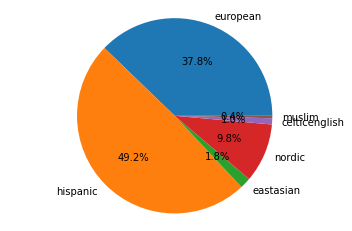

In [ ]:
pred = lstm_model.predict(X_train)
labels = 'european','hispanic','eastasian', 'nordic', 'celticenglish','muslim'
sizes = pred[3564]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

## *Plot Prediction Confusion Matrix*

In [ ]:
pred = model.predict(X_train)

In [ ]:
def plot_confusionHeatmap(pred, y_real): # one-hot encoded
  pred_arr = [0 for i in range(len(pred))]
  y_real_arr = [0 for i in range(len(y_real))]
  for i in range(len(pred)): # to numPy
    pred_arr[i] = np.argmax(pred[i])
    # y_real_np = y_real.numpy()
    y_real_np = y_real
    y_real_arr[i] = np.argmax(y_real_np[i])
  
  confusion_mat = tf.math.confusion_matrix(pred_arr, y_real_arr) # row: real, col: pred
  confusion_mat = confusion_mat.numpy()
  labels = ["European", "Hispanic", "East-Asian", "Nordic", "Celtic-English", "Muslim"]

  fig, ax = plt.subplots()
  im = ax.imshow(confusion_mat)

  # show all ticks
  ax.set_xticks(np.arange(len(labels)))
  ax.set_yticks(np.arange(len(labels)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(labels)
  ax.set_yticklabels(labels)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(labels)):
      for j in range(len(labels)):
          text = ax.text(j, i, confusion_mat[i, j],
                        ha="center", va="center", color="w")

  ax.set_title("Confusion Matrix For Model")
  ax.set_xlabel('Predicted Label')
  ax.set_ylabel('Real Label')
  fig.tight_layout()
  plt.show()

# **Train with Oversampling**




## **From Scratch**

In [ ]:
NUM_OF_EACH_CLASS = 35926 #np.average(counts)
print(NUM_OF_EACH_CLASS)
NUM_OF_TRAIN = y_train.get_shape().as_list()[0]
print(NUM_OF_TRAIN)

35926
74375


In [ ]:
def ovrsampling(X_train, y_train, ETH_DIM, NUM_OF_EACH_CLASS) :
  a = np.argmax(y_train, axis=1)
  # unique, counts = np.unique(a, return_counts=True)
  # dict(zip(unique, counts))

  indices = [] # inidices of each ethnicity in training data
  for i in range(ETH_DIM):
    indices.append([])
    for j in range(len(a)):
      if a[j] == i:
        indices[i].append(j)
  
  new_index = []
  for i in range(ETH_DIM) :
    diff = int(abs(len(indices[i]) - NUM_OF_EACH_CLASS))
    temp = indices[i]
    # print(temp)
    if len(indices[i]) > NUM_OF_EACH_CLASS :
      for j in range(diff):
        id = random.choice(temp)
        temp.remove(id)
    else :
      for j in range(diff) :
        id = random.choice(indices[i])
        temp.insert(0, id)
    new_index.append(temp)

  X_train_sampled = []
  y_train_sampled = []

  for i in range(ETH_DIM):
    X_train_sampled.extend(X_train.numpy()[new_index[i]])
    y_train_sampled.extend(np.array(y_train)[new_index[i]])


  X_train_sampled = tf.convert_to_tensor(X_train_sampled, dtype=tf.int64)
  y_train_sampled = tf.convert_to_tensor(y_train_sampled, dtype=tf.int64)

  return X_train_sampled, y_train_sampled

In [ ]:
X_train_sampled, y_train_sampled = ovrsampling(X_train, y_train, ETH_DIM, NUM_OF_EACH_CLASS)
EPOCH_NUM = 4
# BATCH_SIZE = 1024 use skip-gram parameter
activate_lstm = 'relu'
activate_out = 'softmax'
dropout = 0.5
learning_rate = 0.003
model = LSTM_model(embedding_layer, embedding_dim, activate_lstm, activate_out, dropout, ETH_DIM, learning_rate)
model.fit(X_train_sampled, y_train_sampled, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, validation_split=0.2)

Epoch 1/4
2695/2695 [==============================] - 146s 54ms/step - loss: 0.8543 - categorical_accuracy: 0.7101 - val_loss: 10.3512 - val_categorical_accuracy: 0.1414
Epoch 2/4
2695/2695 [==============================] - 145s 54ms/step - loss: 176094.2263 - categorical_accuracy: 0.6891 - val_loss: 195479.1875 - val_categorical_accuracy: 0.1279
Epoch 3/4
2695/2695 [==============================] - 146s 54ms/step - loss: 15041.5216 - categorical_accuracy: 0.2021 - val_loss: 20935.5332 - val_categorical_accuracy: 0.0170
Epoch 4/4
2695/2695 [==============================] - 147s 55ms/step - loss: 800.5142 - categorical_accuracy: 0.2154 - val_loss: 11337.3164 - val_categorical_accuracy: 0.0604


In [ ]:
model_testing(X_test, y_test)

582/582 [==============================] - 4s 6ms/step - loss: 1086.8531 - categorical_accuracy: 0.2995
Test result: [1086.8531494140625, 0.29950520396232605]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.52      0.45      0.48      8984
           1       0.23      0.18      0.20      2702
           2       0.28      0.20      0.23      2191
           3       0.10      0.07      0.08      1983
           4       0.09      0.35      0.14      1442
           5       0.00      0.00      0.00      1292

    accuracy                           0.30     18594
   macro avg       0.20      0.21      0.19     18594
weighted avg       0.33      0.30      0.31     18594



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **imblearn package**


In [ ]:
x = X_train.numpy()
y = y_train.numpy()

In [ ]:
# random sampling minority class (all equals to num of majority class)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
a = np.argmax(y_resampled, axis=1) # Convert one-hot to index
unique, counts = np.unique(a, return_counts=True)
dict(zip(unique, counts))

{0: 35926, 1: 35926, 2: 35926, 3: 35926, 4: 35926, 5: 35926}

In [ ]:
EPOCH_NUM = 4
# BATCH_SIZE = 1024 use skip-gram parameter
activate_lstm = 'relu'
activate_out = 'softmax'
dropout = 0.5
learning_rate = 0.003
model = LSTM_model(embedding_layer, embedding_dim, activate_lstm, activate_out, dropout, ETH_DIM, learning_rate)
model.fit(X_resampled, y_resampled, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, validation_split=0.2)

Epoch 1/4
2695/2695 [==============================] - 146s 54ms/step - loss: 0.8476 - categorical_accuracy: 0.7002 - val_loss: 0.8528 - val_categorical_accuracy: 0.6860
Epoch 2/4
2695/2695 [==============================] - 143s 53ms/step - loss: 3507223.0663 - categorical_accuracy: 0.6963 - val_loss: 214604.1094 - val_categorical_accuracy: 0.0107
Epoch 3/4
2695/2695 [==============================] - 144s 54ms/step - loss: 8997008.4839 - categorical_accuracy: 0.2043 - val_loss: 2098651.7500 - val_categorical_accuracy: 0.0422
Epoch 4/4
2695/2695 [==============================] - 143s 53ms/step - loss: 1998370.0789 - categorical_accuracy: 0.1960 - val_loss: 56595.6680 - val_categorical_accuracy: 0.0077


In [ ]:
model_testing(X_test, y_test)

582/582 [==============================] - 3s 6ms/step - loss: 44761.5039 - categorical_accuracy: 0.3005
Test result: [44761.50390625, 0.30047327280044556]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.49      0.49      0.49      8984
           1       0.14      0.31      0.19      2702
           2       0.08      0.02      0.03      2191
           3       0.10      0.14      0.12      1983
           4       0.10      0.01      0.01      1442
           5       0.03      0.00      0.00      1292

    accuracy                           0.30     18594
   macro avg       0.16      0.16      0.14     18594
weighted avg       0.29      0.30      0.28     18594



### **SMOTE**

In [ ]:
X_resampled_smote, y_resampled_smote = SMOTE().fit_sample(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
EPOCH_NUM = 2
# BATCH_SIZE = 1024 use skip-gram parameter
activate_lstm = 'relu'
activate_out = 'softmax'
dropout = 0.5
learning_rate = 0.003
model = LSTM_model(embedding_layer, embedding_dim, activate_lstm, activate_out, dropout, ETH_DIM, learning_rate)
model.fit(X_resampled_smote, y_resampled_smote, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, validation_split=0.2)

Epoch 1/2
2695/2695 [==============================] - 144s 53ms/step - loss: 1.3607 - categorical_accuracy: 0.5155 - val_loss: 5.5875 - val_categorical_accuracy: 0.1337
Epoch 2/2
2695/2695 [==============================] - 150s 56ms/step - loss: 0.7130 - categorical_accuracy: 0.7223 - val_loss: 6.2231 - val_categorical_accuracy: 0.1768


In [ ]:
model_testing(X_test, y_test)

582/582 [==============================] - 3s 6ms/step - loss: 0.4311 - categorical_accuracy: 0.8628
Test result: [0.4310760200023651, 0.8627514243125916]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.85      0.92      0.89      8984
           1       0.88      0.84      0.86      2702
           2       0.96      0.91      0.93      2191
           3       0.85      0.82      0.84      1983
           4       0.78      0.66      0.71      1442
           5       0.85      0.72      0.78      1292

    accuracy                           0.86     18594
   macro avg       0.86      0.81      0.83     18594
weighted avg       0.86      0.86      0.86     18594



### **ADASYN**

In [ ]:
X_resampled_adasyn, y_resampled_adasyn = ADASYN().fit_sample(x, y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
EPOCH_NUM = 2
# BATCH_SIZE = 1024 use skip-gram parameter
activate_lstm = 'relu'
activate_out = 'softmax'
dropout = 0.5
learning_rate = 0.003
LSTM_model(embedding_layer, embedding_dim, activate_lstm, activate_out, dropout, ETH_DIM, learning_rate)
model.fit(X_resampled_adasyn, y_resampled_adasyn, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, validation_split=0.2)

Epoch 1/2
2679/2679 [==============================] - 150s 56ms/step - loss: 0.7075 - categorical_accuracy: 0.7213 - val_loss: 8.1701 - val_categorical_accuracy: 0.1202
Epoch 2/2
2679/2679 [==============================] - 150s 56ms/step - loss: 0.6728 - categorical_accuracy: 0.7351 - val_loss: 7.2066 - val_categorical_accuracy: 0.1534


In [ ]:
model_testing(X_test, y_test)

582/582 [==============================] - 4s 6ms/step - loss: 0.4060 - categorical_accuracy: 0.8677
Test result: [0.4059793949127197, 0.8676992654800415]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8984
           1       0.83      0.88      0.86      2702
           2       0.94      0.91      0.93      2191
           3       0.92      0.77      0.84      1983
           4       0.75      0.78      0.76      1442
           5       0.84      0.74      0.79      1292

    accuracy                           0.87     18594
   macro avg       0.86      0.83      0.84     18594
weighted avg       0.87      0.87      0.87     18594



## **Train with Class Weights**


In [ ]:
def generate_class_weights(y_train) :
  y_integers = np.argmax(y_train, axis=1)
  class_weights = class_weight.compute_class_weight('balanced', np.unique(y_integers), y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

In [ ]:
class_weights = generate_class_weights(y_train)
EPOCH_NUM = 4
# BATCH_SIZE = 1024 use skip-gram parameter
activate_lstm = 'relu'
activate_out = 'softmax'
dropout = 0.5
learning_rate = 0.0035
model = LSTM_model(embedding_layer, embedding_dim, activate_lstm, activate_out, dropout, ETH_DIM, learning_rate)
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_NUM, validation_split=0.2, class_weight=class_weights)

Epoch 1/4
930/930 [==============================] - 55s 57ms/step - loss: 1.4284 - categorical_accuracy: 0.4218 - val_loss: 0.8730 - val_categorical_accuracy: 0.6721
Epoch 2/4
930/930 [==============================] - 52s 55ms/step - loss: 0.5951 - categorical_accuracy: 0.7235 - val_loss: 0.7163 - val_categorical_accuracy: 0.7249
Epoch 3/4
930/930 [==============================] - 50s 54ms/step - loss: 0.4890 - categorical_accuracy: 0.7773 - val_loss: 0.7153 - val_categorical_accuracy: 0.7421
Epoch 4/4
930/930 [==============================] - 51s 54ms/step - loss: 0.4663 - categorical_accuracy: 0.7879 - val_loss: 0.6237 - val_categorical_accuracy: 0.7803


In [ ]:
model_testing(X_test, y_test)

582/582 [==============================] - 3s 6ms/step - loss: 0.5442 - categorical_accuracy: 0.8145
Test result: [0.5441681146621704, 0.8145100474357605]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.92      0.74      0.82      8984
           1       0.80      0.88      0.84      2702
           2       0.90      0.93      0.91      2191
           3       0.75      0.86      0.80      1983
           4       0.58      0.88      0.70      1442
           5       0.66      0.86      0.75      1292

    accuracy                           0.81     18594
   macro avg       0.77      0.86      0.80     18594
weighted avg       0.84      0.81      0.82     18594



## **Tune Parameters**

In [ ]:
# EPOCH_NUM_ARR = list(range(600, 801, 200))
# BATCH_SIZE_ARR = [1024, 2048]

In [ ]:
# scores = []
# for aEPOCH_NUM in EPOCH_NUM_ARR:
#   for aBATCH_SIZE in BATCH_SIZE_ARR:
#     model.fit(X_train, y_train, batch_size=aBATCH_SIZE, epochs=aEPOCH_NUM, verbose=0)
#     temp_score = model.evaluate(X_train, y_train)
#     scores.append(temp_score)

# **textCNN - static**

In [ ]:
def text_cnn (max_len, embed_weights, embed_dim, learning_rate, filter_sizes):
  text_seq = Input(shape=[max_len], name='x_seq')
  emb_text = embedding_layer(embed_weights, embed_dim)(text_seq)
  # convolution layer
  convs = []
  for fsz in filter_sizes:
    l_conv = Conv1D(filters=100, kernel_size=fsz, activation='tanh')(emb_text)
    l_pool = MaxPooling1D(max_len - fsz + 1)(l_conv)
    l_pool = Flatten()(l_pool)
    convs.append(l_pool)
  merge = concatenate(convs, axis=1)

  out = Dropout(0.5)(merge)
  output = Dense(units=32, activation='relu')(out)
  output = Dense(units=6, activation='sigmoid')(output)

  model = Model([text_seq], output)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
  return model

In [ ]:
def cnn_testing(X_test, y_test):
  score = cnn_model.evaluate(X_test, y_test)
  print("Test result:", score)
  y_test_oneHot = np.argmax(y_test, axis=1) # Convert one-hot to index
  y_pred = cnn_model.predict(X_test)
  y_pred = np.argmax(y_pred,axis=1)
  print(classification_report(y_test_oneHot, y_pred))
  plot_confusionHeatmap(y_pred, y_test_oneHot)

In [ ]:
filter_sizes_sets = [[2, 3, 4], [3, 4, 5], [2, 4, 6], [3, 5, 7], [1, 2, 3, 4, 5]]
for fszs in filter_sizes_sets:
  print("filter_sizes =", fszs)
  cnn_model = text_cnn(MAX_SEQUENCE_LENGTH, weights, embedding_dim, learning_rate=0.003, filter_sizes=fszs)
  cnn_model.fit(X_train, y_train, validation_split=0, batch_size=64, epochs=5, verbose=0)
  cnn_testing(X_test, y_test)

filter_sizes = [2, 3, 4]
582/582 [==============================] - 2s 3ms/step - loss: 0.3111 - categorical_accuracy: 0.9021
Test result: [0.3111214339733124, 0.9020651578903198]
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      8984
           1       0.91      0.87      0.89      2702
           2       0.96      0.93      0.95      2191
           3       0.91      0.88      0.89      1983
           4       0.83      0.81      0.82      1442
           5       0.88      0.79      0.84      1292

    accuracy                           0.90     18594
   macro avg       0.90      0.87      0.88     18594
weighted avg       0.90      0.90      0.90     18594

filter_sizes = [3, 4, 5]
582/582 [==============================] - 2s 3ms/step - loss: 0.3052 - categorical_accuracy: 0.9055
Test result: [0.30523818731307983, 0.9055071473121643]
              precision    recall  f1-score   support

           0       0.91      0.94      0.

In [ ]:
cnn_model = text_cnn(MAX_SEQUENCE_LENGTH, weights, embedding_dim, learning_rate=0.003, filter_sizes=[3, 5, 7])
cnn_model.fit(X_train, y_train, validation_split=0, batch_size=64, epochs=5, verbose=0)
cnn_testing(X_test, y_test)

582/582 [==============================] - 3s 5ms/step - loss: 0.3052 - categorical_accuracy: 0.9051
Test result: [0.3052125573158264, 0.9050769209861755]


582/582 [==============================] - 3s 5ms/step - loss: 0.3052 - categorical_accuracy: 0.9051
Test result: [0.3052125573158264, 0.9050769209861755]
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      8984
           1       0.90      0.89      0.89      2702
           2       0.96      0.94      0.95      2191
           3       0.91      0.88      0.89      1983
           4       0.85      0.81      0.83      1442
           5       0.87      0.81      0.84      1292

    accuracy                           0.91     18594
   macro avg       0.90      0.88      0.89     18594
weighted avg       0.90      0.91      0.90     18594



IndexError: ignored

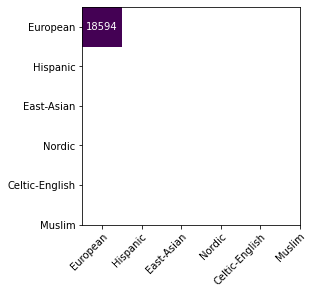

In [ ]:
cnn_testing(X_test, y_test)

### **with class weight**

In [ ]:
cnn_model.fit(X_train, y_train, validation_split=0.2, batch_size=64, epochs=5, class_weight=generate_class_weights(y_train))

NameError: ignored

In [ ]:
cnn_testing(X_test, y_test)

582/582 [==============================] - 2s 3ms/step - loss: 0.4481 - categorical_accuracy: 0.8453
Test result: [0.44814133644104004, 0.8452726602554321]
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      8984
           1       0.84      0.90      0.87      2702
           2       0.95      0.93      0.94      2191
           3       0.83      0.90      0.86      1983
           4       0.71      0.90      0.79      1442
           5       0.55      0.93      0.69      1292

    accuracy                           0.85     18594
   macro avg       0.80      0.89      0.83     18594
weighted avg       0.87      0.85      0.85     18594

